In [1]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import pandas as pd
import csv
import openpyxl
import os
import pickle
import datetime
from scipy import signal
from detecta import detect_peaks
# import matrixprofile as mp
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import minkowski

import sktime
import pywt
import cv2 as cv

# from fastdtw import fastdtw
import subprocess
# from dtw import dtw

import warnings
warnings.simplefilter("ignore")
from platform import python_version
print(python_version())
import time

3.8.8


# Read Wrist and Annotation Data

## Fuctions for Reading the Data

In [2]:
def readData(accDir, annotFile):
    files = os.listdir(accDir)
    files_csv = [f for f in files if f[-3:] == 'csv']
    empatica_dict = dict()
    for f in files_csv:
        data = np.genfromtxt(accDir+f, delimiter=',') # creates numpy array for each Empatica acc csv file
        key = int(float(f.strip("ACC.csv")))
        empatica_dict[key] = data
    tmp = pd.read_excel(annotFile, sheet_name=None)
    annot_dict = dict(zip(tmp.keys(), [i.dropna() for i in tmp.values()])) # Remove the rows with NaN values (some with ladder 2 missing)
    return empatica_dict, annot_dict

def getLabeledDict(empatica_dict, annot_dict, subject_ids):
    labeled_dict = {}; taskInd_dict = {}
    for id in subject_ids:
        start_time = int(empatica_dict[id][0,0])
        acc = empatica_dict[id][2:,:]
        label = list(map(lambda i: i.replace("_end", "").replace("_start", ""), annot_dict['P'+ str(id)].taskName.tolist()))
        task_time= list(map(lambda i: time.mktime(datetime.datetime.strptime(i[:6] + '20' + i[6:], "%m/%d/%Y %H:%M:%S").timetuple()),
                            annot_dict['P'+ str(id)].startTime_global.tolist()))
        task_ind = [int(x - start_time)*SR for x in task_time]
        taskInd_dict[id] = task_ind
        label_tmp = np.empty(acc.shape[0], dtype=object)
        for i, (j, k) in enumerate(zip(task_ind[0::2], task_ind[1::2])):
            tmpInd = 2*i
            label_tmp[j:k] = label[tmpInd]
        acc_mag = np.sqrt(np.sum(acc**2, axis=1))[:,None]
        accel = np.hstack((acc, acc_mag))
        labeled_dict[id] = pd.DataFrame(np.hstack((accel, label_tmp.reshape(label_tmp.shape[0],1))), columns=['X', 'Y', 'Z', 'Mag', 'label'])
    return labeled_dict, taskInd_dict

## Read the Data

In [3]:
sepAccDict, sepAnnotDict = readData(accDir='./Data/50_subs/Acc Data/separate/', annotFile='./Data/50_subs/Annotation Data/separate.xlsx')
SR=int(sepAccDict[8][1,0])

sepSubIDs = list(range(8,45))
sepSubIDs.remove(27) # does not have lift
sepLabeledDict_, sepTaskIndDict = getLabeledDict(sepAccDict, sepAnnotDict, sepSubIDs)

## Apply Low Pass Filter

In [4]:
# Apply Filter on All Subjects
n=4; fc=2; w=fc/(SR/2)
b, a = signal.butter(n, w, 'low')
sepLabeledDict_filtered = dict(map(lambda key: (key, signal.filtfilt(b, a, x=sepLabeledDict_[key].drop(columns='label'), axis=0)), sepLabeledDict_.keys()))
# back to DF and add label
sepLabeledDict_filtered_dfs = dict(map(lambda key: (
                                                        key, pd.DataFrame(sepLabeledDict_filtered[key],columns=['X', 'Y', 'Z', 'Mag']).assign(label=sepLabeledDict_[key].label)
                                                    ), sepLabeledDict_filtered.keys()))
# Remove data without label
filt_noNA_dict = dict(map(lambda key: (key, sepLabeledDict_filtered_dfs[key].dropna()), sepLabeledDict_filtered_dfs.keys()))

<AxesSubplot:>

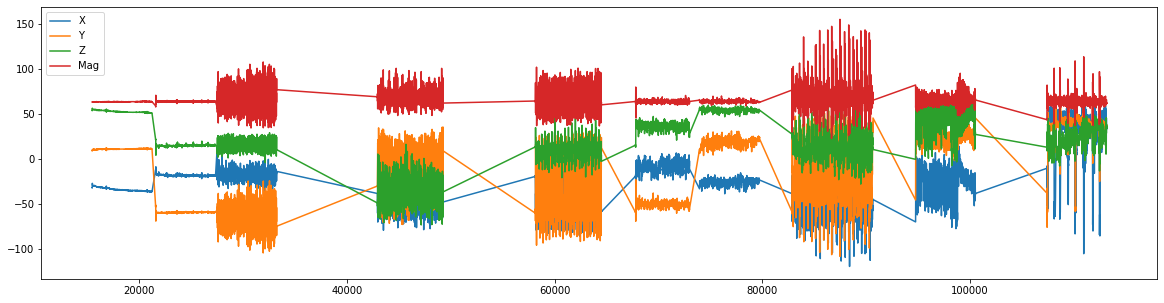

In [6]:
f, ax = plt.subplots(1, figsize=(20,5))
filt_noNA_dict[8].plot(ax=ax)
# ax.set_xlim([30000, 32000])

## Isolate all Tasks for one Subject

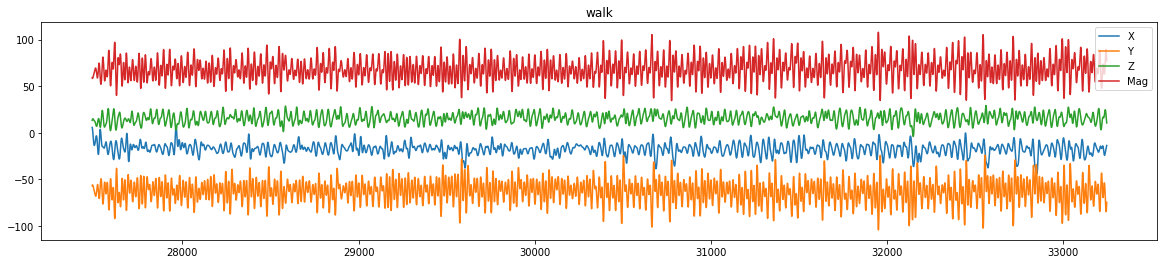

In [6]:
label = filt_noNA_dict[8].label.unique()
i = 2
f, ax = plt.subplots(1, figsize=(20,4))
filt_noNA_dict[8][filt_noNA_dict[8].label==label[i]].plot(ax=ax, legend=True)
ax.set_title(label[i])
plt.show()

# Power Spectrum of Y Signal

## Lift subject 8

In [7]:
tmp = pywt.wavelist(kind='continuous')
print(tmp)

['cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan']


In [5]:
label = 'walk'
sub = 8
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

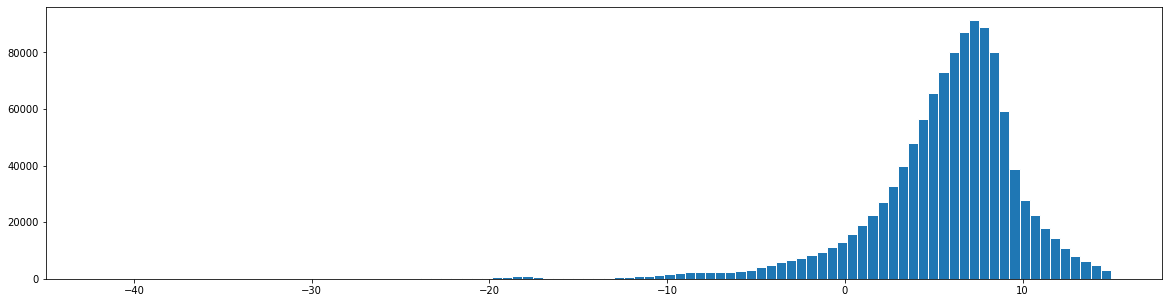

In [6]:
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

power_logscale = np.log2(power)
for_hist =power_logscale.flatten()
f, ax = plt.subplots(1,1, figsize=(20,5))
ax.hist(for_hist, bins=100, edgecolor='w')
plt.show()

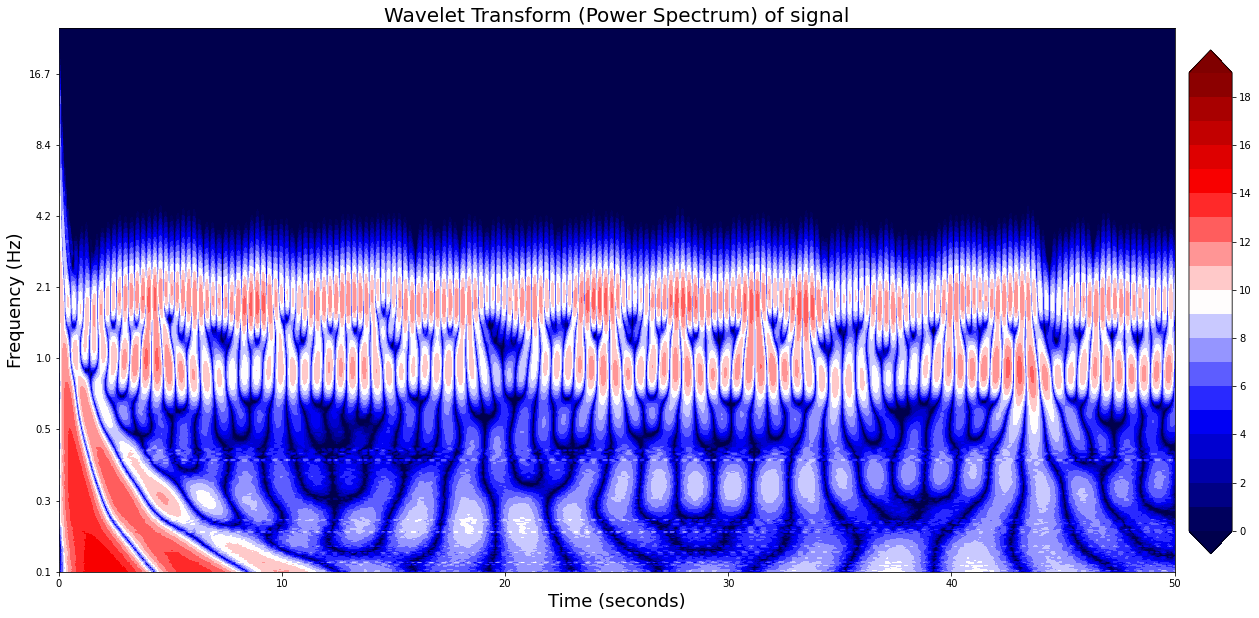

In [7]:
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2
contourlevels = np.arange(0, 20)

############################### Plot
f, ax = plt.subplots(figsize=(20, 10))
im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=plt.cm.seismic)# np.log2(power)
ax.set_title('Wavelet Transform (Power Spectrum) of signal', fontsize=20)
ax.set_ylabel('Frequency (Hz)', fontsize=18)
ax.set_xlabel('Time (seconds)', fontsize=18)
cbar_ax = f.add_axes([0.91, 0.15, 0.03, 0.7])
f.colorbar(im, cax=cbar_ax, orientation="vertical")
yticks = np.arange(np.log2(frequencies).min(), np.log2(frequencies).max())
ax.set_yticks(yticks)
ax.set_yticklabels(np.round(2**(yticks), 1))
ax.set_xlim([0, 50])
plt.show()

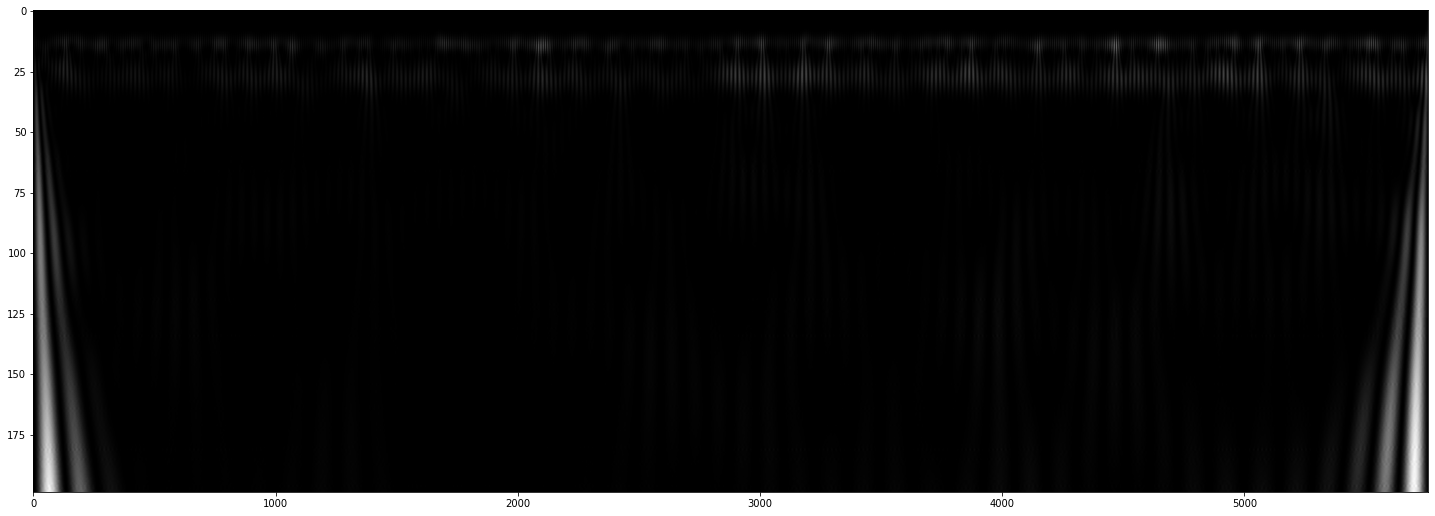

In [11]:
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(power, cmap='gray', aspect=10)
plt.show()

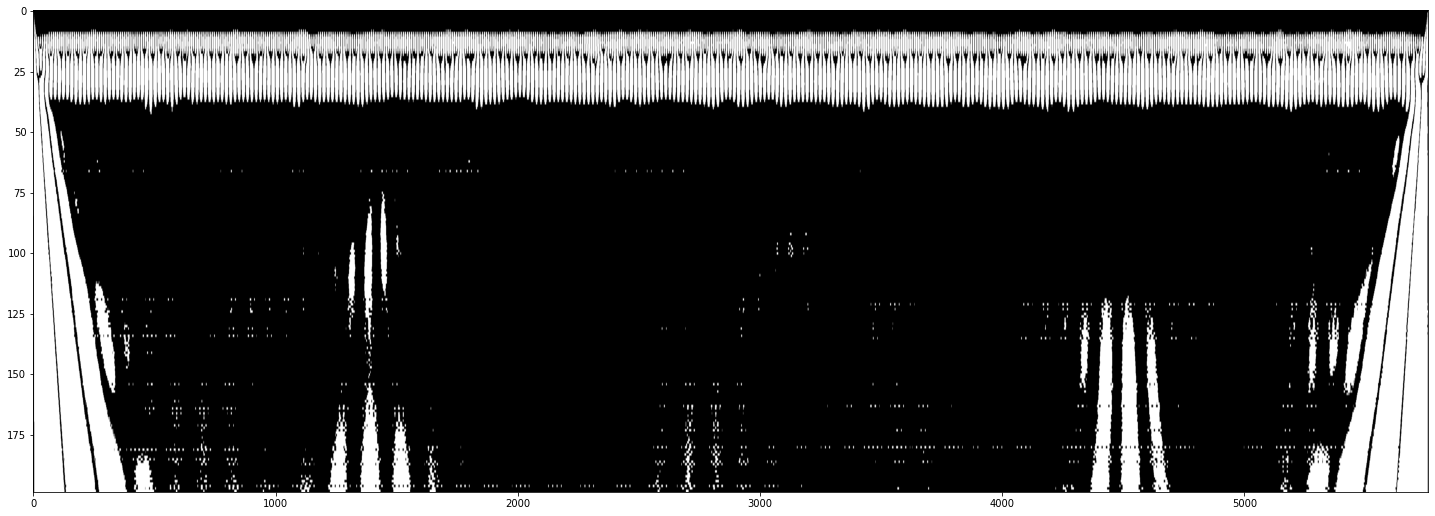

In [35]:
label = 'walk'
sub = 9
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values

#####
SR=1/32
time = np.arange(0, sig.shape[0]) * SR
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_20perc = np.percentile(power, 80)
power_binary = np.zeros(shape=power.shape)
power_binary[np.where(power>power_20perc)]=255

aa = power_binary#[:50,:1000]

############# Plot
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(aa, cmap='gray', aspect=10)
# ax.set_ylim([10,70])
plt.show()

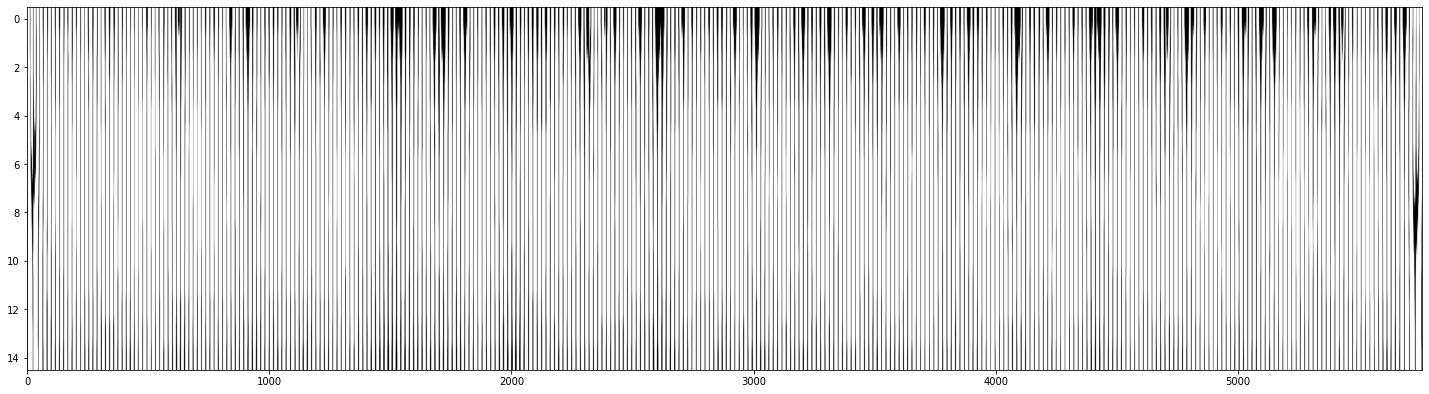

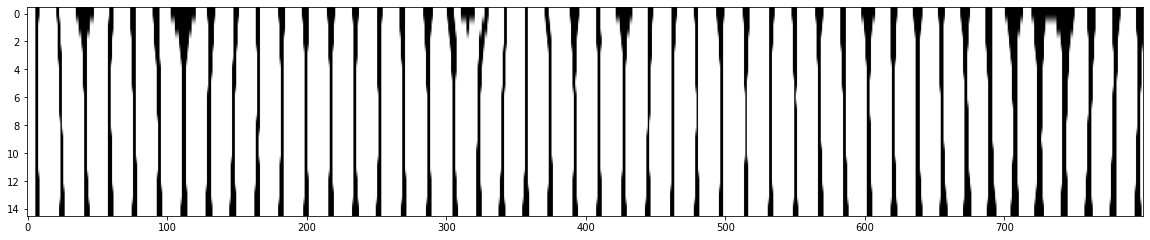

In [112]:
label = 'walk'
sub = 9
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_thresh = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_thresh)]=255
ret, thresh_img__ = cv.threshold(power, power_thresh, 255, cv.THRESH_BINARY)
thresh_img_ = thresh_img__.astype('uint8')
thresh_img = thresh_img_[20:35,:]

############# Plot
f, ax = plt.subplots(1, figsize=(25,10))
ax.imshow(thresh_img, cmap='gray', aspect=100)
plt.show()

############# Plot
f, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(thresh_img[:,800:1600], cmap='gray', aspect=10)
plt.show()

number of detected contours = 162.0


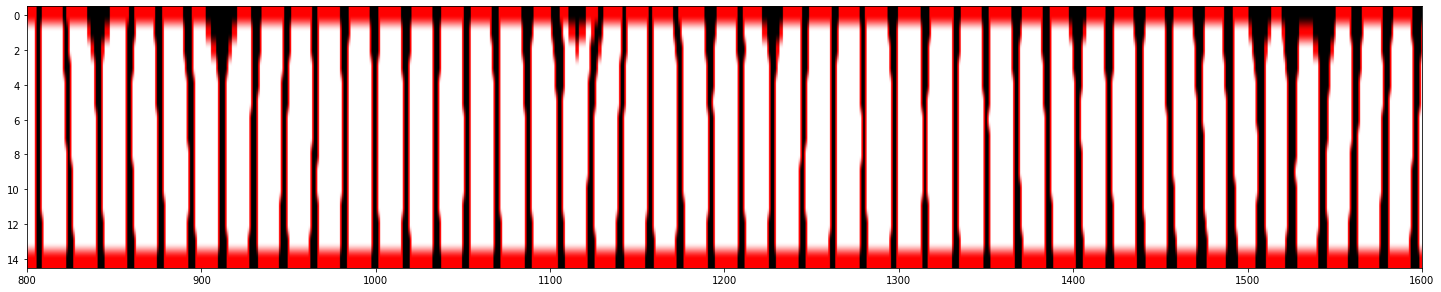

In [113]:
contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/2, 0)))

######### Plot
f, ax = plt.subplots(figsize=(25,10))
im = np.expand_dims(thresh_img.copy(), axis=2).repeat(3, axis=2) 
for k, _ in enumerate(large_contours):
    im = cv.drawContours(im, large_contours, k, (255, 0, 0), 1)
plt.imshow(im, aspect=10)
plt.xlim([800, 1600])
plt.show()

In [126]:
label = 'walk'
sub = 20
sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values
################# For setting the contourlevels
SR=1/32
scales = np.arange(1, 200)
[coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
power = (abs(coefficients)) ** 2

## Thresholding on powerespectrom to binarize the image
power_thresh = np.percentile(power, 80)
# power_binary = np.zeros(shape=power.shape)
# power_binary[np.where(power>power_thresh)]=255
ret, thresh_img = cv.threshold(power, power_thresh, 255, cv.THRESH_BINARY)
thresh_img_ = thresh_img.astype('uint8')
thresh_img = thresh_img_[20:35,:]

############# find contours and count
contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
area = [cv.contourArea(cnt) for cnt in contours]
area_thresh = np.percentile(area, 90)*0.3
contours_np = np.array(contours)
area_np = np.array(area)
large_contours = contours_np[np.where(area_np>area_thresh)]
print('number of detected contours = {}'.format(round(large_contours.shape[0]/2, 0)))

number of detected contours = 164.0


# Count Number of Steps (Only Right Foot) in All Subjects

In [5]:
label = 'walk'
walk_count_dict = {}
for sub in filt_noNA_dict.keys():
    sig = filt_noNA_dict[sub][filt_noNA_dict[sub].label==label].Y.values
    
    scales = np.arange(1, 200)
    [coefficients, frequencies] = pywt.cwt(sig, scales, 'morl', sampling_period=SR)
    power = (abs(coefficients)) ** 2

    power_20perc = np.percentile(power, 80)
    ret, thresh_img__ = cv.threshold(power, power_20perc, 255, cv.THRESH_BINARY)
    thresh_img_ = thresh_img__.astype('uint8')
    thresh_img = thresh_img_[20:35,:]

    contours, hierarchy = cv.findContours(thresh_img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    area = [cv.contourArea(cnt) for cnt in contours]
    area_thresh = np.percentile(area, 90)*0.3
    contours_np = np.array(contours)
    area_np = np.array(area)
    large_contours = contours_np[np.where(area_np>area_thresh)]
    walk_count_dict[sub] = round(large_contours.shape[0]/2, 0)

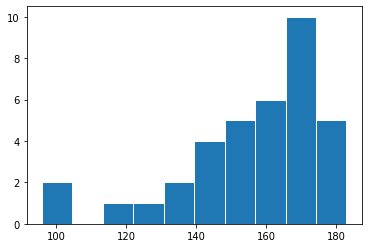

In [7]:
f, ax = plt.subplots(1)
ax.hist(walk_count_dict.values(), edgecolor='w')
# ax.xaxis.set_ticks(np.arange(18,23))
plt.show()